In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import Union, Optional, Dict, Tuple, Any

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score

In [3]:
water = pd.read_csv('../datasets/daily_water_intake/Daily_Water_Intake.csv').dropna(how='all')
water

,Age,Gender,Weight (kg),Daily Water Intake (liters),Physical Activity Level,Weather,Hydration Level
0,56,Male,96,4.23,Moderate,Hot,Good
1,60,Male,105,3.95,High,Normal,Good
2,36,Male,68,2.39,Moderate,Cold,Good
3,19,Female,74,3.13,Moderate,Hot,Good
4,38,Male,77,2.11,Low,Normal,Poor
...,...,...,...,...,...,...,...
29995,47,Male,97,3.45,Moderate,Cold,Good
29996,49,Female,109,5.32,High,Hot,Good
29997,56,Female,54,1.50,Moderate,Cold,Poor
29998,36,Male,106,4.00,Low,Hot,Good


In [4]:
water.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          30000 non-null  int64  
 1   Gender                       30000 non-null  object 
 2   Weight (kg)                  30000 non-null  int64  
 3   Daily Water Intake (liters)  30000 non-null  float64
 4   Physical Activity Level      30000 non-null  object 
 5   Weather                      30000 non-null  object 
 6   Hydration Level              30000 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.8 MB


In [5]:
print("Age", water['Age'].min(), " - ", water['Age'].max())

Age 18  -  69


In [6]:
print("Weight (kg)", water['Weight (kg)'].min(), " - ", water['Weight (kg)'].max())

Weight (kg) 45  -  109


In [7]:
print("Daily Water Intake (liters)", water['Daily Water Intake (liters)'].min(), " - ", water['Daily Water Intake (liters)'].max())

Daily Water Intake (liters) 1.5  -  5.43


In [8]:
water['Physical Activity Level'].value_counts()

Physical Activity Level
High        10069
Low         10011
Moderate     9920
Name: count, dtype: int64

In [9]:
water['Weather'].value_counts()

Weather
Hot       10081
Cold      10012
Normal     9907
Name: count, dtype: int64

In [10]:
water['Hydration Level'].value_counts()

Hydration Level
Good    23915
Poor     6085
Name: count, dtype: int64

In [11]:
def show_classification_report(y_true, y_pred):
    print("        [ CLASSIFICATION REPORT ]")
    print(classification_report(y_true, y_pred))
    print(f"Overall Accuracy: {accuracy_score(y_true, y_pred):.4f}")

In [12]:
def classification_plots(model, x_test, y_test):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax)
    plt.title('ROC-AUC Curve')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [14]:
def preprocess(
    data: pd.DataFrame
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    data = data.copy()
    data_info: Dict[str, Any] = {}

    data["Gender"] = (data["Gender"] == "Male")
    
    categorical_cols = ['Weather', 'Physical Activity Level']
    data = pd.get_dummies(data, columns=categorical_cols, dtype='int8')
    data_info['categorical_cols'] = categorical_cols

    scaler = StandardScaler()
    cols_to_scale = [
        'Age', 
        'Weight (kg)',
        'Daily Water Intake (liters)',
    ]
    data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])
    data_info['cols_to_scale'] = cols_to_scale
    data_info['scaler'] = scaler
    
    dtype_map = {
        'Age': 'float32',
        'Weight (kg)': 'float32',
        'Daily Water Intake (liters)': 'float32',
        'Gender': 'int8',
    }
    data = data.astype(dtype_map)

    data_info['dtype_map'] = dtype_map
    data_info['data_columns'] = data.columns.tolist()

    return data, data_info

In [15]:
def preprocess_test(data: pd.DataFrame, data_info: Dict[str, Any]) -> pd.DataFrame:
    data = data.copy()

    data["Gender"] = (data["Gender"] == "Male")
    
    categorical_cols = data_info['categorical_cols']
    existing_cat_cols = [c for c in categorical_cols if c in data.columns]
    data = pd.get_dummies(data, columns=existing_cat_cols, dtype='int8')

    scaler = data_info['scaler']
    cols_to_scale = data_info['cols_to_scale']
    if all(col in data.columns for col in cols_to_scale):
        data[cols_to_scale] = scaler.transform(data[cols_to_scale])

    data = data.reindex(columns=data_info['data_columns'], fill_value=0)

    dtype_map = data_info['dtype_map']
    for col, dtype in dtype_map.items():
        if col in data.columns:
            data[col] = data[col].astype(dtype)

    return data

In [18]:
water['Hydration Level'] = (water["Hydration Level"] == "Good").astype('int8')
y = water['Hydration Level']
x = water.drop('Hydration Level', axis=1)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [20]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((24000, 6), (6000, 6), (24000,), (6000,))

In [21]:
x_train_p, data_info = preprocess(x_train)

In [22]:
x_train_p

,Age,Gender,Weight (kg),Daily Water Intake (liters),Weather_Cold,Weather_Hot,Weather_Normal,Physical Activity Level_High,Physical Activity Level_Low,Physical Activity Level_Moderate
3225,-1.499717,0,-0.848728,0.757059,0,1,0,1,0,0
11815,-0.031375,0,-1.222423,-1.607365,0,0,1,0,1,0
7338,0.035368,1,0.112202,-0.755212,0,0,1,0,1,0
14980,1.503710,1,-0.208108,-1.475341,1,0,0,0,1,0
27167,0.168854,1,-0.261493,-1.055266,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
13123,-1.166003,1,-1.596118,-0.695201,0,1,0,0,0,1
19648,0.903025,1,-1.275808,0.216962,0,1,0,1,0,0
9845,1.637196,1,0.272357,0.036930,1,0,0,1,0,0
10799,-1.633203,1,-1.489349,-1.631369,1,0,0,0,1,0


In [23]:
data_info

{'categorical_cols': ['Weather', 'Physical Activity Level'],
 'cols_to_scale': ['Age', 'Weight (kg)', 'Daily Water Intake (liters)'],
 'scaler': StandardScaler(),
 'dtype_map': {'Age': 'float32',
  'Weight (kg)': 'float32',
  'Daily Water Intake (liters)': 'float32',
  'Gender': 'int8'},
 'data_columns': ['Age',
  'Gender',
  'Weight (kg)',
  'Daily Water Intake (liters)',
  'Weather_Cold',
  'Weather_Hot',
  'Weather_Normal',
  'Physical Activity Level_High',
  'Physical Activity Level_Low',
  'Physical Activity Level_Moderate']}

In [24]:
x_test_p = preprocess_test(x_test, data_info)

In [25]:
x_test_p

,Age,Gender,Weight (kg),Daily Water Intake (liters),Weather_Cold,Weather_Hot,Weather_Normal,Physical Activity Level_High,Physical Activity Level_Low,Physical Activity Level_Moderate
8225,-0.365089,0,-0.208108,0.096941,0,1,0,0,1,0
10794,-0.632060,1,0.485897,-0.815223,1,0,0,0,1,0
9163,-1.566460,1,0.646052,-0.299130,0,0,1,0,1,0
26591,-0.565317,1,-0.261493,-0.095094,0,1,0,0,1,0
6631,1.436968,1,-0.581803,-1.175287,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
12715,-1.566460,1,0.165587,1.153131,0,0,1,1,0,0
28867,-0.632060,1,0.058817,-1.583361,1,0,0,0,1,0
3758,1.303482,0,-0.795343,0.144950,0,1,0,1,0,0
17842,1.036511,1,0.272357,-0.275126,1,0,0,1,0,0


In [26]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train_p, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

In [27]:
xgb_pred_train = xgb_model.predict(x_train_p)
xgb_pred_train

array([1, 0, 0, ..., 1, 1, 1], shape=(24000,))

In [28]:
show_classification_report(y_train, xgb_pred_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4861
           1       1.00      1.00      1.00     19139

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000

Overall Accuracy: 1.0000


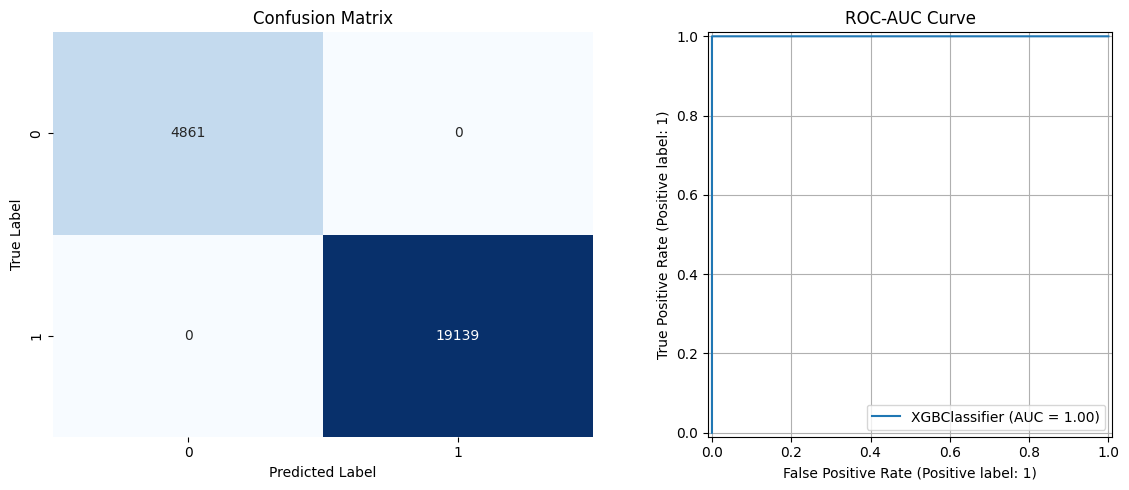

In [29]:
classification_plots(xgb_model, x_train_p, y_train)

In [30]:
xgb_pred = xgb_model.predict(x_test_p)
xgb_pred

array([1, 0, 0, ..., 1, 1, 1], shape=(6000,))

In [31]:
show_classification_report(y_test, xgb_pred)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1224
           1       1.00      1.00      1.00      4776

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Overall Accuracy: 0.9977


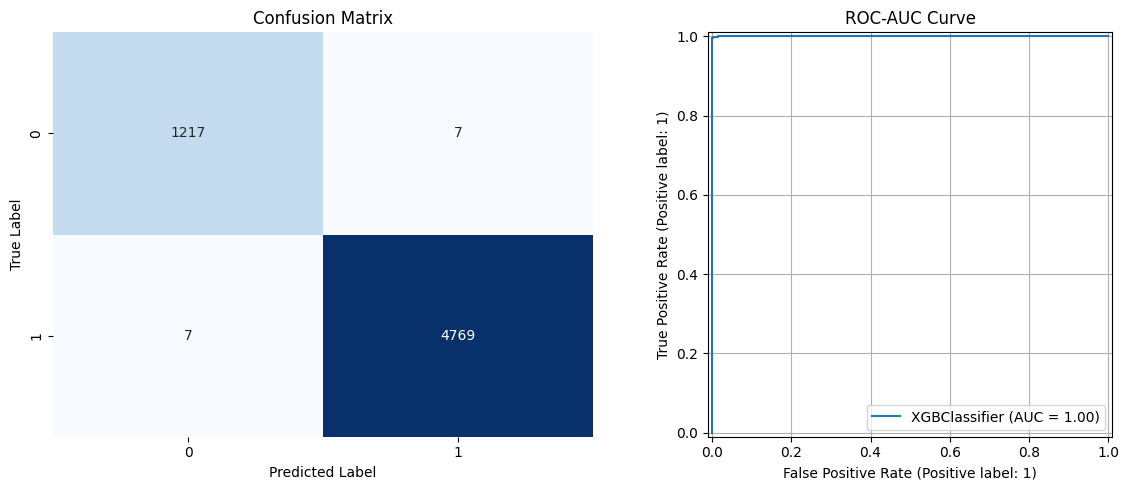

In [32]:
classification_plots(xgb_model, x_test_p, y_test)

In [61]:
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, random_state=42, class_weight='balanced')
dt_model.fit(x_train_p, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

In [62]:
dt_pred_train = dt_model.predict(x_train_p)
dt_pred_train

array([1, 0, 0, ..., 1, 1, 1], shape=(24000,), dtype=int8)

In [63]:
show_classification_report(y_train, dt_pred_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      4861
           1       1.00      0.95      0.97     19139

    accuracy                           0.96     24000
   macro avg       0.91      0.97      0.94     24000
weighted avg       0.96      0.96      0.96     24000

Overall Accuracy: 0.9552


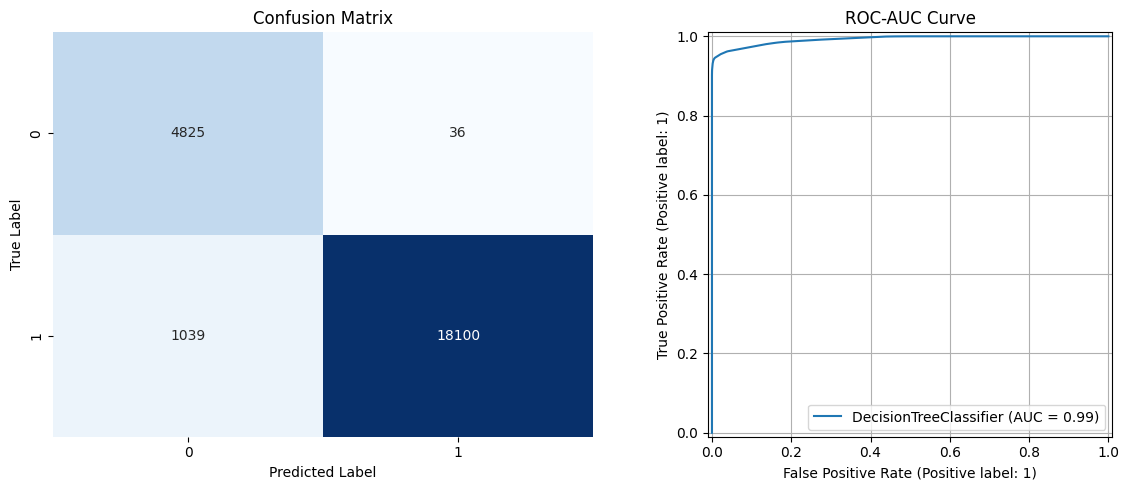

In [65]:
classification_plots(dt_model, x_train_p, y_train)

In [66]:
dt_pred = dt_model.predict(x_test_p)
dt_pred

array([1, 0, 0, ..., 1, 1, 1], shape=(6000,), dtype=int8)

In [67]:
show_classification_report(y_test, dt_pred)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1224
           1       0.99      0.94      0.96      4776

    accuracy                           0.94      6000
   macro avg       0.90      0.96      0.92      6000
weighted avg       0.95      0.94      0.95      6000

Overall Accuracy: 0.9450


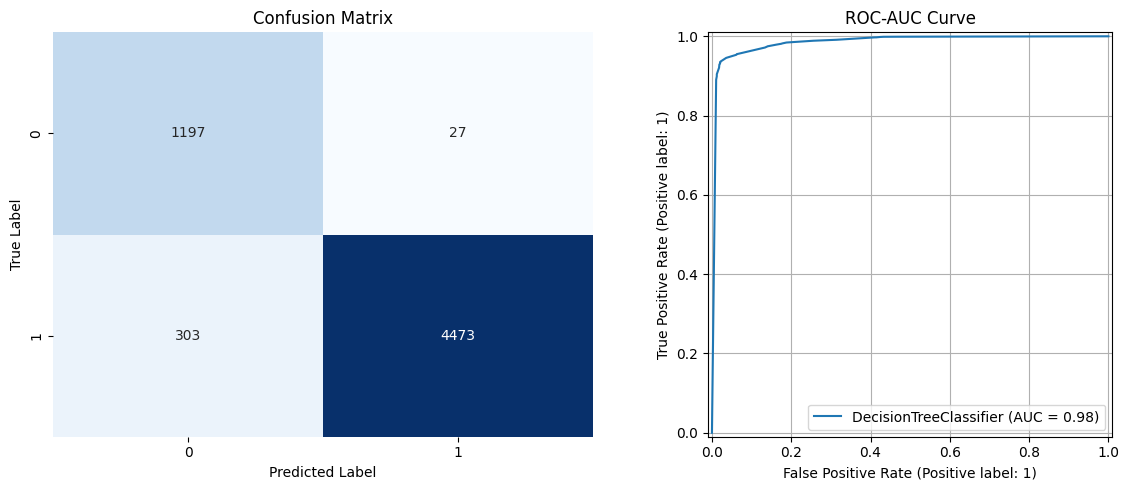

In [68]:
classification_plots(dt_model, x_test_p, y_test)

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(x_train_p, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [34]:
rf_pred_train = rf_model.predict(x_train_p)
rf_pred_train

array([1, 0, 0, ..., 1, 1, 1], shape=(24000,), dtype=int8)

In [35]:
show_classification_report(y_train, rf_pred_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4861
           1       0.99      0.99      0.99     19139

    accuracy                           0.99     24000
   macro avg       0.98      0.98      0.98     24000
weighted avg       0.99      0.99      0.99     24000

Overall Accuracy: 0.9862


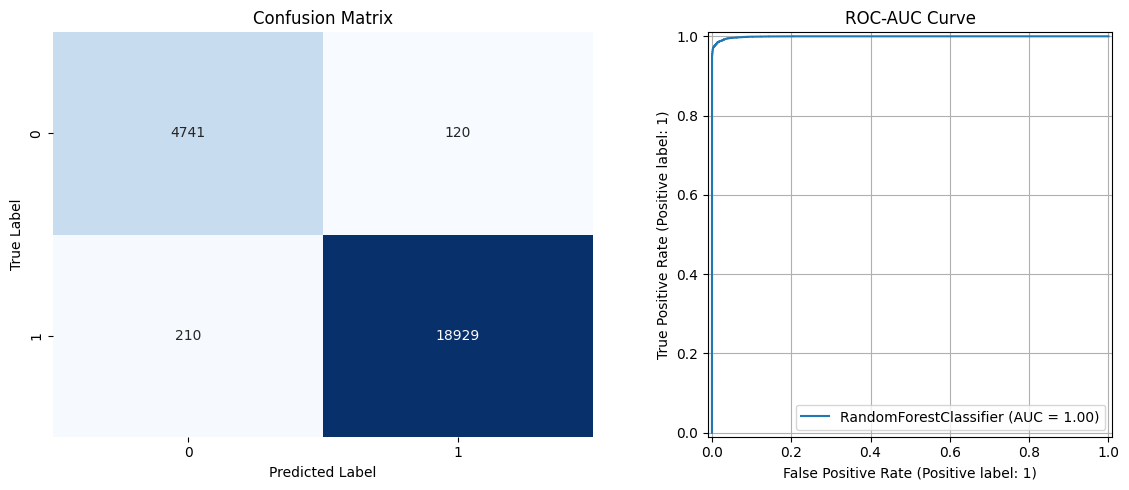

In [36]:
classification_plots(rf_model, x_train_p, y_train)

In [37]:
rf_pred = rf_model.predict(x_test_p)
rf_pred

array([1, 0, 0, ..., 1, 1, 1], shape=(6000,), dtype=int8)

In [38]:
show_classification_report(y_test, rf_pred)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1224
           1       0.99      0.98      0.98      4776

    accuracy                           0.97      6000
   macro avg       0.95      0.96      0.96      6000
weighted avg       0.97      0.97      0.97      6000

Overall Accuracy: 0.9720


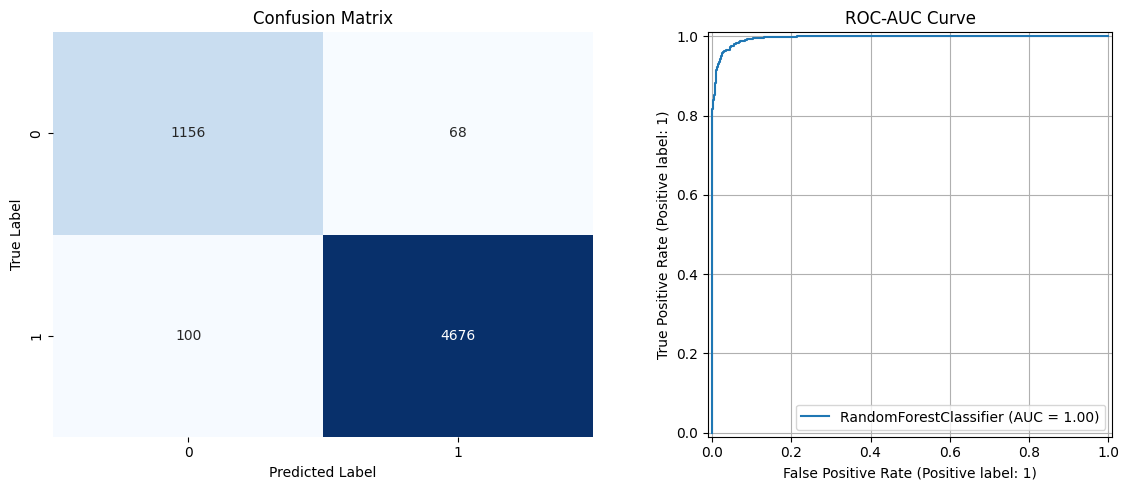

In [39]:
classification_plots(rf_model, x_test_p, y_test)

In [40]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_p, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [42]:
knn_pred_train = knn_model.predict(x_train_p)
knn_pred_train

array([1, 0, 0, ..., 1, 1, 1], shape=(24000,), dtype=int8)

In [43]:
show_classification_report(y_train, knn_pred_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4861
           1       0.99      0.99      0.99     19139

    accuracy                           0.99     24000
   macro avg       0.98      0.98      0.98     24000
weighted avg       0.99      0.99      0.99     24000

Overall Accuracy: 0.9862


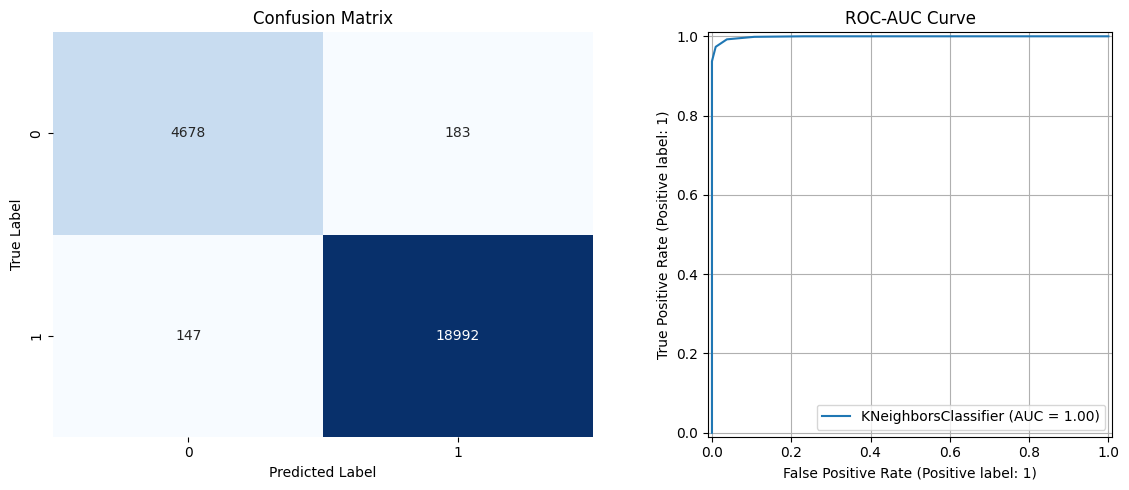

In [44]:
classification_plots(knn_model, x_train_p, y_train)

In [45]:
knn_pred = knn_model.predict(x_test_p)
knn_pred

array([1, 0, 1, ..., 1, 0, 1], shape=(6000,), dtype=int8)

In [46]:
show_classification_report(y_test, knn_pred)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1224
           1       0.98      0.98      0.98      4776

    accuracy                           0.97      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.97      0.97      0.97      6000

Overall Accuracy: 0.9697


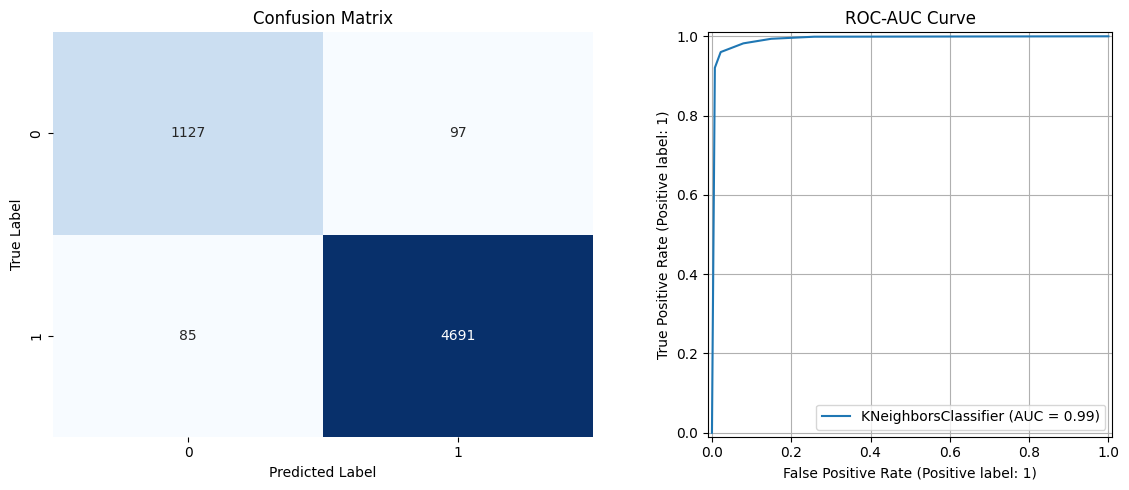

In [47]:
classification_plots(knn_model, x_test_p, y_test)

In [52]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(x_train_p, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [53]:
lr_pred_train = lr_model.predict(x_train_p)
lr_pred_train

array([1, 0, 0, ..., 1, 1, 1], shape=(24000,), dtype=int8)

In [54]:
show_classification_report(y_train, lr_pred_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4861
           1       1.00      1.00      1.00     19139

    accuracy                           1.00     24000
   macro avg       1.00      0.99      1.00     24000
weighted avg       1.00      1.00      1.00     24000

Overall Accuracy: 0.9969


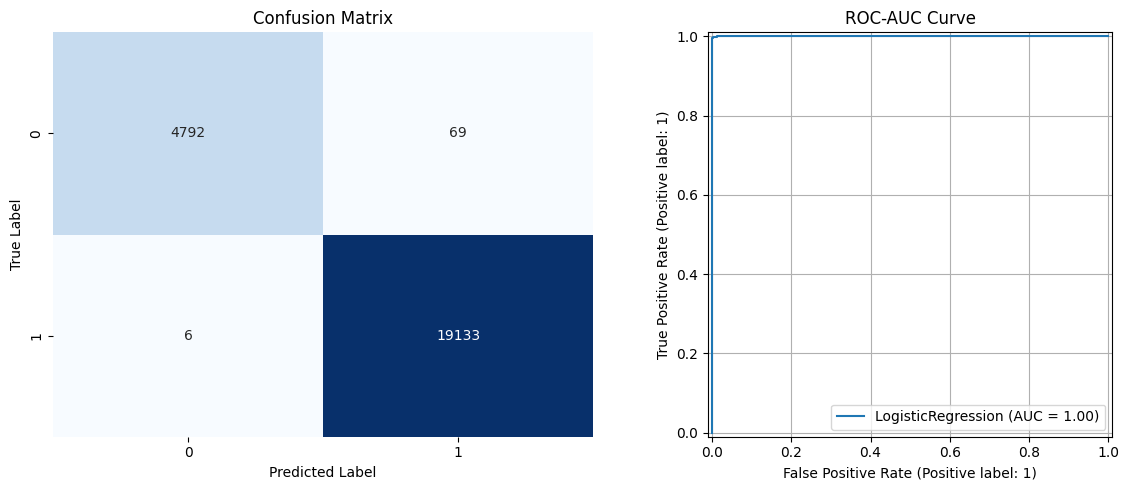

In [56]:
classification_plots(lr_model, x_train_p, y_train)

In [57]:
lr_pred = lr_model.predict(x_test_p)
lr_pred

array([1, 0, 0, ..., 1, 1, 1], shape=(6000,), dtype=int8)

In [58]:
show_classification_report(y_test, lr_pred)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1224
           1       1.00      1.00      1.00      4776

    accuracy                           1.00      6000
   macro avg       1.00      0.99      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Overall Accuracy: 0.9972


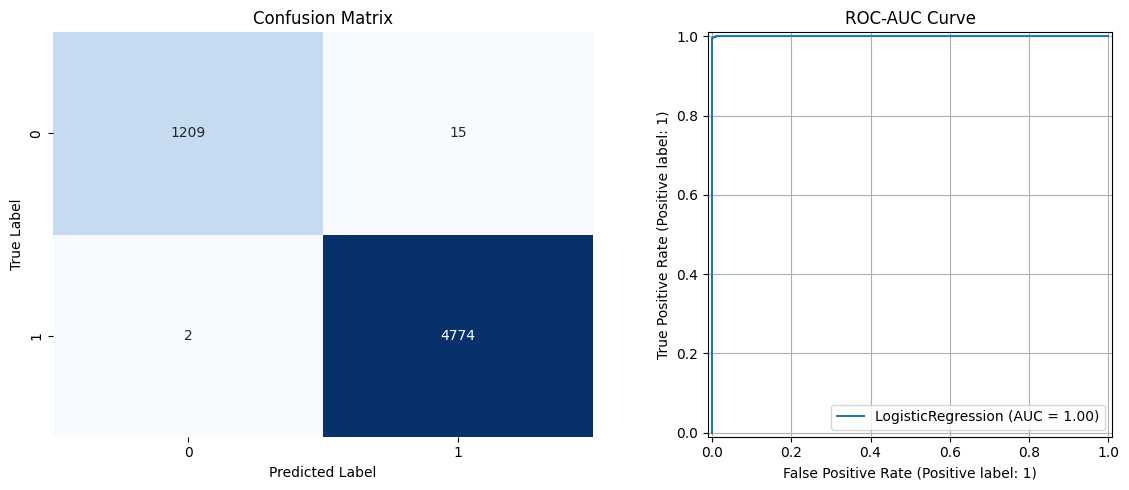

In [59]:
classification_plots(lr_model, x_test_p, y_test)

In [69]:
gnb_model = GaussianNB()
gnb_model.fit(x_train_p, y_train)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [70]:
gnb_pred_train = gnb_model.predict(x_train_p)
gnb_pred_train

array([1, 0, 0, ..., 1, 0, 1], shape=(24000,), dtype=int8)

In [71]:
show_classification_report(y_train, gnb_pred_train)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.54      0.95      0.69      4861
           1       0.98      0.80      0.88     19139

    accuracy                           0.83     24000
   macro avg       0.76      0.87      0.79     24000
weighted avg       0.89      0.83      0.84     24000

Overall Accuracy: 0.8277


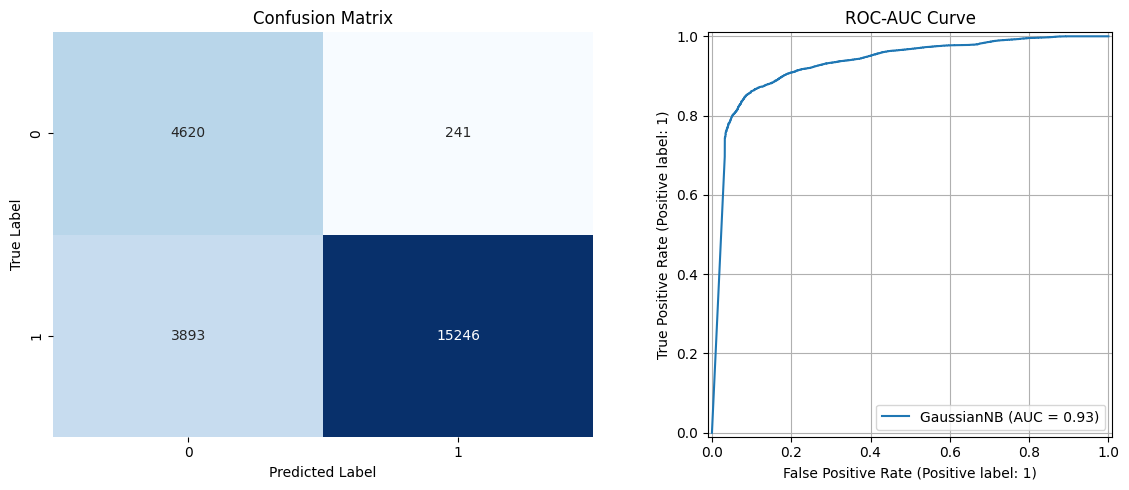

In [72]:
classification_plots(gnb_model, x_train_p, y_train)

In [73]:
gnb_pred = gnb_model.predict(x_test_p)
gnb_pred

array([1, 0, 0, ..., 1, 1, 1], shape=(6000,), dtype=int8)

In [74]:
show_classification_report(y_test, gnb_pred)

        [ CLASSIFICATION REPORT ]
              precision    recall  f1-score   support

           0       0.52      0.95      0.68      1224
           1       0.98      0.78      0.87      4776

    accuracy                           0.81      6000
   macro avg       0.75      0.87      0.77      6000
weighted avg       0.89      0.81      0.83      6000

Overall Accuracy: 0.8140


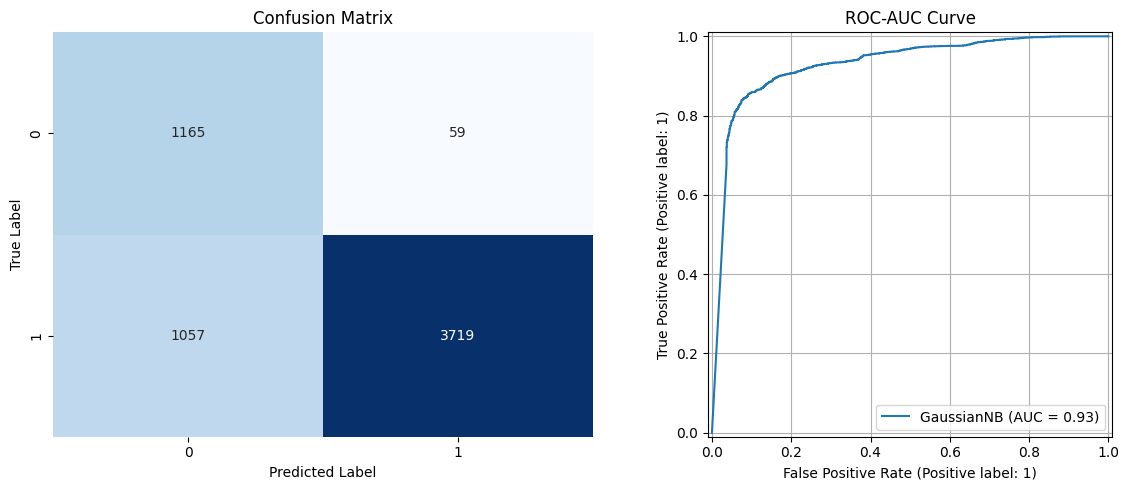

In [75]:
classification_plots(gnb_model, x_test_p, y_test)